## What does this notebook do?
This notebook accesses data from [space-track.org](https://www.space-track.org/) to analyse the age distribution of active payloads in LEO. The data is a part of space-track's [gp](https://www.space-track.org/documentation#api-basicSpaceDataGp) class ( general perturbations ), which is an efficient listing of the newest SGP4 keplerian element set for each artificial earth-orbiting object tracked by the 18th Space Defense Squadron.

## Requirements:
To use this notebook, replace 'username' and 'password' with your existing login credentials. Uncomment and run the required line below to ensure necessary packages are present locally/ in the cloud.

In [1]:
# %pip install matplotlib numpy pandas requests seaborn sgp4

In [2]:
from datetime import date
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from sgp4.api import Satrec

In [3]:
username = None
password = None

if not username or not password:
  print("Enter valid credentials")

siteCred = { 'identity': username, 'password': password }

In [4]:
# Error class to handle 'POST' and 'GET' errors
class HandleError(Exception):
    def __init__(self, args):
        Exception.__init__(self, "Exception raised with args {0}".format(args))
        self.args = args

# Function to calculate the altitude
def calculate_altitude(row):  
        objRec = Satrec.twoline2rv(row['TLE_LINE1'], row['TLE_LINE2'])
        objPos = objRec.sgp4(row['JULIAN_DATE'], row['FRACTION'])[1]
        satAlt = np.sqrt(objPos[0]**2 + objPos[1]**2 + objPos[2]**2) - 6371
        return satAlt

In [5]:
uriBase = "https://www.space-track.org"
requestLogin = "/ajaxauth/login"
requestQuery = "/basicspacedata/query"

# OBJECT_TYPE = PAYLOAD
satPayload = "/class/gp/OBJECT_TYPE/PAYLOAD"

# Orders the data by NORAD_CAT_ID
orderBy = "/orderby/NORAD_CAT_ID%20asc"

===== Top 10 Objects < 25y =====
          OBJECT_NAME   LIFESPAN
4809  GLOBALSTAR M023  24.936345
4811  GLOBALSTAR M036  24.936345
4812  GLOBALSTAR M038  24.936345
4810  GLOBALSTAR M040  24.936345
4816            ARGOS  24.898015
4817           ORSTED  24.898015
4818           SUNSAT  24.898015
4825  GLOBALSTAR M046  24.843258
4826  GLOBALSTAR M037  24.843258
4824  GLOBALSTAR M041  24.843258

===== Top 10 Objects > 25y =====
         OBJECT_NAME   LIFESPAN
4         VANGUARD 2  64.914442
8         VANGUARD 3  64.331280
9         EXPLORER 7  64.262834
13           TIROS 1  63.794661
19        TRANSIT 2A  63.570157
20   SOLRAD 1 (GREB)  63.570157
26        COURIER 1B  63.285421
44       EXPLORER 11  62.724162
46        TRANSIT 4A  62.551677
47  SOLRAD 3/INJUN 1  62.551677

Number of active payloads: 9745
Number of payloads > 25 y: 1350


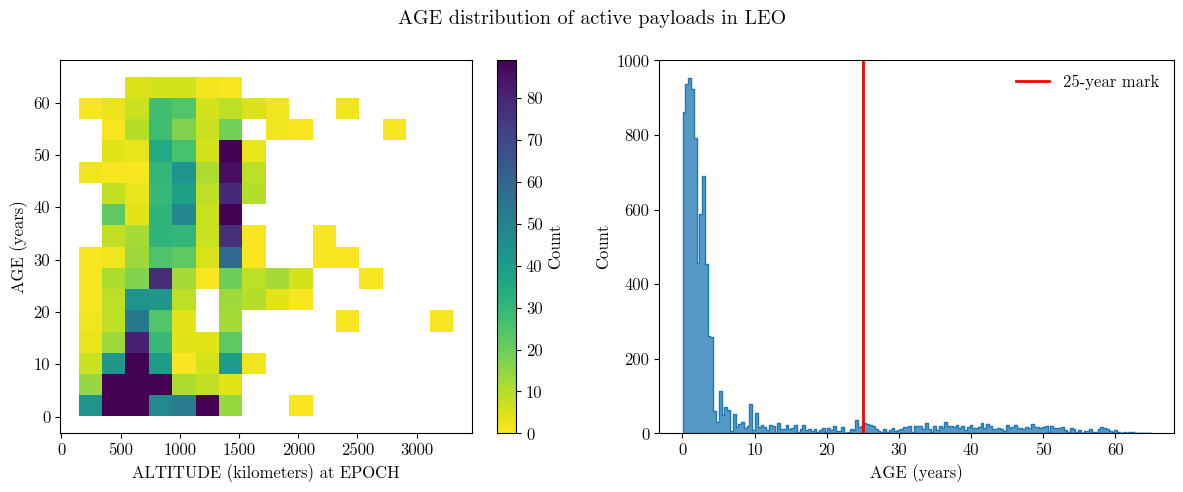

In [6]:
with requests.Session() as session:
    postCheck = session.post(uriBase + requestLogin, data = siteCred)
    if postCheck.status_code != 200:
            raise HandleError('POST')

    
    # Requests for PAYLOAD data
    response1 = session.get(uriBase + requestQuery + satPayload + orderBy)
    if response1.status_code != 200:
        raise HandleError('GET')
    
    data1 = response1.text
    
    dataFrame1 = pd.read_json(io.StringIO(data1))

    """
    Using any available fonts is permissible for the plots, 
    but I chose CMU Serif for aesthetic reasons.
    For Ubuntu, you can install the font package fonts-cmu 
    (using sudo apt install fonts-cmu), which contains the fonts.
    """
    # plt.rcParams['font.family'] = "CMU Serif"
    # plt.rcParams['font.size'] = 12
    
    # Drops the PAYLOAD data where DECAY_DATE != null
    dataFrame1 = dataFrame1[dataFrame1['DECAY_DATE'].isnull()]
    
    dataFrame1 = dataFrame1[dataFrame1['MEAN_MOTION'] > 11.25]

    # Plots the ALTITUDE (kilometers) at EPOCH vs INCLINATION for active payloads in LEO
    dataFrame1['EPOCH'] = pd.to_datetime(dataFrame1['EPOCH'])
    dataFrame1['JULIAN_DATE'] = dataFrame1['EPOCH'].apply(lambda x: int(x.to_julian_date()))
    dataFrame1['FRACTION'] = dataFrame1['EPOCH'].apply(lambda x: x.to_julian_date() - int(x.to_julian_date()))
    dataFrame1['ALTITUDE'] = dataFrame1.apply(lambda row: calculate_altitude(row), axis = 1)

    fig, axes = plt.subplots(1, 2, figsize = (12, 5))
        
    # Plots the ALTITUDE (kilometers) at EPOCH vs LIFESPAN for active payloads in LEO
    dataFrame1['LAUNCH_DATE'] = pd.to_datetime(dataFrame1['LAUNCH_DATE'])
    dataFrame1['DECAY_DATE'] = pd.to_datetime(date.today())
    dataFrame1['LIFESPAN'] = ((dataFrame1['DECAY_DATE'] - dataFrame1['LAUNCH_DATE']).dt.days) / 365.25  

    sns.histplot(x = 'ALTITUDE', y = 'LIFESPAN', data = dataFrame1, cmap = 'viridis_r',
                 cbar = True,
                 cbar_kws = {'label': 'Count'},
                 bins = 16, ax = axes[0], pmax = 0.2)
    
    axes[0].set_xlabel("ALTITUDE (kilometers) at EPOCH")
    axes[0].set_ylabel("AGE (years)")

    sns.histplot(x = 'LIFESPAN', data = dataFrame1, element = 'step', ax = axes[1])
    
    axes[1].set_xlabel("AGE (years)")
    axes[1].set_ylabel('Count')

    axes[1].axvline(x = 25, color = 'red', linewidth = 2, label = "25-year mark")
    axes[1].legend(frameon = False)

    plt.suptitle("AGE distribution of active payloads in LEO")

    plt.tight_layout()

    preTwentyFive = dataFrame1[(dataFrame1['LIFESPAN'] < 25)]
    topTen1 = preTwentyFive.sort_values(by = 'LIFESPAN', ascending = False).head(10)

    posTwentyFive = dataFrame1[(dataFrame1['LIFESPAN'] > 25)]  
    topTen2 = posTwentyFive.sort_values(by = 'LIFESPAN', ascending = False).head(10)  

    print("===== Top 10 Objects < 25y =====")
    print(topTen1[['OBJECT_NAME', 'LIFESPAN']])
    print()

    print("===== Top 10 Objects > 25y =====")
    print(topTen2[['OBJECT_NAME', 'LIFESPAN']])
    print()

    print("Number of active payloads:", dataFrame1['NORAD_CAT_ID'].count())
    print("Number of payloads > 25 y:", posTwentyFive['NORAD_CAT_ID'].count())
    
session.close()